Important concepts of lecture 4:

* from n-hot vectors (sparse) to embeddings (dense inputs)
* baselines for your projects (classification, sequence prediction)
* short introduction to RNNs

# Neural Networks - Representations

### Recap: Feed-forward Neural Network


$$NN_{MLP1}(\mathbf{x})=g(\mathbf{xW^1+b^1})\mathbf{W^2}+\mathbf{b^2}$$

<img src="pics/yg-compgraph1.png">



However, what is the input $\textbf{x}$?

## Recap: Features so far


Before we go further, lets make a detour and recap: How did we represent a training instance in a traditional classifier so far?

For instance, recall our example from week 1: training a Logistic Regression classifier for sentiment classification. 

* Describe in words: what were the features we used? I.e., how did we represent a training instance $\textbf{x}$?
* How can you now describe the entire sentiment training data set as a matrix $X$, i.e.,  what are the rows and columns of $X$? $$ X = \{\mathbf{x_1}, ... , \mathbf{x_n}\} $$ 

So far we used **sparse** inputs (n-hot encodings).

After this lecture you should:
* know about **distributional similarity** (embeddings: --traditional:LSA--, --neural:word2vec--)
* understand the difference between **discrete** (one-hot) and **dense** feature representations

# Representations

**discrete representation**

$$\mathbf{x}_{cat} = [0,0,0,0,0,0,1] $$
$$\mathbf{x}_{dog} = [0,0,0,0,1,0,0] $$

**similarity** on discrete representations? $$\mathbf{x}_{cat} \wedge \mathbf{x}_{dog} = 0$$

Probably the biggest jump when moving from traditional linear models with sparse inputs to deep neural networks is to stop representing each feature as a unique dimension, but instead represent them as **dense vectors** (Goldberg, 2015).

Instead of using discrete representations, we will **embed** words into a high-dimensional feature space and represent each word by a lower-dimensional dense *vector* (aka. *embedding*):
<img src="http://ben.bolte.cc/resources/attention_rnn/word_vectors.png">

## Representing words

<center>**"You shall know a word by the company it keeps"** (Firth, J. R. 1957:11)</center>

<img src="pics/flødebolle.png">

### "The company it keeps": word co-occurence matrix

We can represent the "company" of a word in terms of a word co-occurence matrix. On the rows we have the words, on the columns their context.

**Contexts** can be of different types, for example:
* entire documents
* paragraphs
* a window around the word

#### Example corpus

In [47]:
corpus = ["She enjoys Groningen .", "She likes Cockatoos .", "She likes good food", "I like Groningen ."]  

In [48]:
import numpy as np
vocab = set(np.concatenate([s.split() for s in corpus],0))
print(vocab)

{'likes', 'I', 'enjoys', 'Cockatoos', '.', 'good', 'She', 'like', 'food', 'Groningen'}


In [72]:
# lets build a co-occurence matrix 
# rows: indices of words
# columns: each column is a document, register whether the word appeared in the context
## (in practice: many more context, different weighting schemes etc..)
w2i = {w: i for i,w in enumerate(sorted(vocab))}
i2w = {i: w for i,w in enumerate(w2i)}

coocurrence_matrix = np.zeros((len(vocab),len(corpus)))
for col_idx, sentence in enumerate(corpus):
    sentence = sentence.split()
    for word in sentence:
        word_idx = w2i[word]
        coocurrence_matrix[(word_idx,col_idx)] +=1

print("vocab size: ", len(w2i))
print(coocurrence_matrix)

vocab size:  10
[[ 1.  1.  0.  1.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 1.  1.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  1.  1.  0.]]


In [73]:
print("with row info:")
for i, row in enumerate(coocurrence_matrix):
    print("{}\t{}\t{}".format(i, i2w[i], row))

with row info:
0	.	[ 1.  1.  0.  1.]
1	Cockatoos	[ 0.  1.  0.  0.]
2	Groningen	[ 1.  0.  0.  1.]
3	I	[ 0.  0.  0.  1.]
4	She	[ 1.  1.  1.  0.]
5	enjoys	[ 1.  0.  0.  0.]
6	food	[ 0.  0.  1.  0.]
7	good	[ 0.  0.  1.  0.]
8	like	[ 0.  0.  0.  1.]
9	likes	[ 0.  1.  1.  0.]


### Co-occurence matrix

* **dimensionality**: number of words $|V|$ (size of vocabulary) times number of documents (typically number of documents is huge)
* we want to **reduce** its dimensionality

### LSA - Latent Semantic Analysis (Singular Value Decomposition - SVD)

Approximate a matrix $\mathbf{C}$ through a decomposition into three submatrices (**of smaller dimensionality**):

$$\mathbf{C} \approx \mathbf{U \sum V^T}$$

<img src="https://simonpaarlberg.com/posts/2012-06-28-latent-semantic-analyses/box2.png">

NB. $=$ should be $\approx$

In [68]:
from sklearn.utils.extmath import randomized_svd

# reduce space to, say, 2 dimensions (for simplicity here)
U, Sigma, VT = randomized_svd(coocurrence_matrix, 
                              n_components=2)
print(U.shape)

(10, 2)


#### Visualizing the vector space

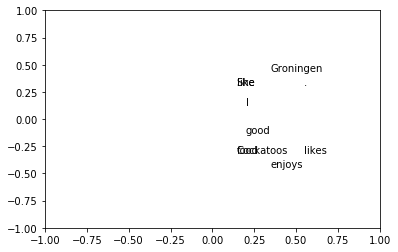

size of U: (10, 2)
vector for 'likes': [ 0.34550151  0.43973261]
vector for 'enjoys': [ 0.20078434 -0.1287947 ]
9
[ 0.34550151  0.43973261]


In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
words = list(vocab)
for i, lab in enumerate(vocab):
    plt.text(U[i,0],U[i,1], words[i])
plt.axis([-1, 1, -1, 1])
plt.show()
print("size of U:", U.shape)
print("vector for 'likes':", U[w2i["likes"]])
print("vector for 'enjoys':", U[w2i["enjoys"]])
print(w2i['likes'])
print(U[9])

### Similarity

**cosine** similarity 

<img src="https://simonpaarlberg.com/posts/2012-06-28-latent-semantic-analyses/eq1.png">
<img src="https://simonpaarlberg.com/posts/2012-06-28-latent-semantic-analyses/vector_example2.png">



**Exercise**: Calculate the cosine distance between the words *good* and *enjoys* as well as *enjoys* and *likes*. (Hint: you can use the *cosine* **distance** function from *scipy.spatial.distance*, notice it is 1 minus cosine similarity). What is the distance between a word and itself?

In [75]:
## solution:
from scipy.spatial.distance import cosine

v_likes = U[w2i["likes"]]
v_enjoys = U[w2i["enjoys"]]
v_good = U[w2i["good"]]

print("cosine distances:")
print("good<>enjoys:     {0:.2f}".format(cosine(v_good, v_enjoys)))
print("enjoys<>likes: {0:.2f}".format(cosine(v_enjoys, v_likes)))
print("good<>good: {0:.2f}".format(cosine(v_good, v_good)))



cosine distances:
good<>enjoys:     1.13
enjoys<>likes: 0.90
good<>good: 0.00


## Deep learning approach: Directly learning word vectors (embeddings)

* SVD: computation cost scales quadratically with size of co-occurence matrix; difficult to integrate new words
* **Idea**: directly learn word vectors (word2vec)
    * NLP (almost) from Scratch (Collobert & Weston, 2008)
    * word2vec (Mikolov et al, 2013)

### Main idea of word2vec

* instead of capturing co-occurence statistics of words
* **predict context** (surrounding words of every word); in particular, predict words in a window of length $m$ around current word

$o$ is the outside word (context), $c$ is the current center word; 

Maximize the probability of a word in the context ($o$) given the current word $c$:

$$p(o|c) = \frac{exp(u_o^T v_c)}{\sum_{w=1}^W exp(u_w^T v_c)}$$

<img src="http://www.gabormelli.com/RKB/images/a/a6/skip-gram_NNLM_architecture.150216.jpg" width=500>

At the end you can read off the embedding vector from the Embedding layer! voila!

NB. denominator $\sum$ over all words! In practice, *negative sampling* is used (randomly choose a word which is not in context as a negative sample)

In deep learning we represent words as vectors.

**a) sparse representation vs b) dense representation**  (Figure 1 in Yoav Goldberg's primer)
<img src="pics/sparsevsdense.png">

#### Traditional vs deep learning approach to feature extraction (representations)

The common pipeline of extracting features **for an NLP model with a Neural Network** then becomes:

* extract a set of core linguistic features $f_1,..f_n$
* define a **vector** for **each feature** (lookup Embedding table)
* **combine** vectors of features to get the vector representation for the **instance** $\mathbf{x}$ (**dense representation**)
* use $\mathbf{x}$ as representation for an instance, train the model


    

Lets compare this to our traditional approach - the common pipeline of extracting features for an NLP model is:

* extract a set of core linguistic features $f_1,..f_n$
* define a vector whose length is the total number of features with a 1 at position k if the k-th feature is active; this feature vector represents the **instance** $\mathbf{x}$  (**sparse representation**, n-hot encoding)
* use $\mathbf{x}$ as representation for an instance, train the model

Now it should be clear why it is called sparse vs dense feature representation.


### How do you combine different feature vector representations?


In an NLP application, $\mathbf{x}$ is usually composed of various embedding vectors.


Following the notation in Goldberg (2015), chapter 4, lets use the function $c(\cdot)$ as **feature combiner** that creates our input embeddings layer.

A common choice for $c$ is **concatenation**:

$\mathbf{x} = c(f_1, f_2, f_3) = [v(f_1); v(f_2); v(f_3)] $

This is what happens if we use **Flatten** in Keras.

Alternatively, $c$ could be the **sum of the embeddings vector**:

$\mathbf{x} = c(f_1, f_2, f3) = [v(f_1)+v(f_2)+v(f_3)] $

or the **mean**:

$\mathbf{x} = c(f_1, f_2, f3) = [mean(v(f_1),v(f_2),v(f_3))] $

In many papers $v$ is often referred to as the embeddings layer or lookup layer.

#### Our example from before with explicit input representation

For instance, let us explicitly state the input representation. Suppose we use the concatentation operator, then our network above becomes:

<img src="pics/nn.png" width=300> 

since: 
$\mathbf{x} = c(f_1, f_2, f3) = [v(f_1); v(f_2); v(f_3)] $

then: 

$NN_{MLP1}(\mathbf{x})=g(\mathbf{[v(f_1); v(f_2); v(f_3)]W^1+b^1})\mathbf{W^2}+\mathbf{b^2}$



As computational graph:
<img src="pics/yg-compgraph2.png">

The values of the *embedding vectors* (values of the vectors in Fig 1 b)) are treated as model parameters and trained together with the other parameters of the model (weights).

Unrolled (graph with concrete input, expected output, and loss node, Goldberg Figure 3 c):
<img src="pics/yg-compgraph3.png">

### Example: animacy classification

Exercise: 

* add an embedding layer to the animacy classification example. For now use a simple concatenation as representation (Flatten the embedding layer). What performance do you get?

* add code that reads off the embedding layer from the network and stores in in a file "vectors.txt". Once you have this embedding vector you can inspect it (find nearest neighbors) as shown below.

In [7]:
# once we have read off the embeddings after training the animacy classifier, and 
# stored them in file 'vectors.txt' we load it for inspection
from gensim.models.keyedvectors import KeyedVectors
w2v = KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)
w2v.most_similar(positive=['Texas'])


[('Florida', 0.9196957945823669),
 ('Arlington', 0.9070820808410645),
 ('California', 0.8937997817993164),
 ('Buffalo', 0.8546850085258484),
 ('Canada', 0.8518165349960327),
 ('Japan', 0.8483419418334961),
 ('Europe', 0.8347345590591431),
 ('Houston', 0.8322141170501709),
 ('Virginia', 0.8314700126647949),
 ('France', 0.8283012509346008)]

In [8]:
w2v.most_similar(positive=['send'])


[('elect', 0.851630449295044),
 ('word', 0.8355662822723389),
 ('letting', 0.8245967030525208),
 ('teach', 0.8199971914291382),
 ('swaying', 0.81275475025177),
 ('parks', 0.811647891998291),
 ('finally', 0.7990972995758057),
 ('wishes', 0.793840765953064),
 ('repainted', 0.7927937507629395),
 ('jus-', 0.787428617477417)]

These vectors are not traditional word vectors learned with word2vec (skipgrams), instead we read them off from our animacy classifier (they are not trained with the word2vec objective, but are a by-product from the classifier). Nevertheless this shows us that we can also get embeddings from a neural network with dense (embedding) inputs! 

### Word Embeddings

So, in deep learning approaches to NLP words are represented as dense vectors. Where do these word vectors (embeddings) come from?

* **randomly initialized** (small numbers around 0) and *trained with the network*
* **off-the-shelf embeddings**: you can also use already trained, available embeddings (e.g. estimated with *word2vec*) and *initialize* the embedding layer of the network with your pretrained (unsupervised) word embeddings
* **task-specific embeddings**: you could also train your embeddings, read them off the network, and use them for another task (or in a multi-task setup, more later)

### Inputs of different lengths

In our animacy classification example we have one simplification: the input is always of the same size (namely, 5 words). 

However, in NLP we typically never have fixed size inputs, sentences are of different length. The neural network however needs inputs of fixed size. So how to deal with it?



* create an input of fixed size, like using the mean embedding vector
* use a model that can deal with variable size inputs, like a recurrent neural network (depending on the deep learning toolkit you use, you might still need to *pad* sequences to a fixed length)


Karpathy's illustration of RNNs:
<img src="http://benjaminbolte.com/resources/attention_rnn/karpathy_rnn.jpeg">

* From left to right: (1) Vanilla mode of processing without RNN, from fixed-sized input to fixed-sized output (e.g. image classification). (2) Sequence output (e.g. image captioning takes an image and outputs a sentence of words). (3) Sequence input (e.g. sentiment analysis where a given sentence is classified as expressing positive or negative sentiment). (4) Sequence input and sequence output (e.g. Machine Translation: an RNN reads a sentence in English and then outputs a sentence in French). (5) Synced sequence input and output (e.g. video classification where we wish to label each frame of the video). Notice that in every case are no pre-specified constraints on the lengths sequences because the recurrent transformation (green) is fixed and can be applied as many times as we like.*

## Important concepts: Prediction problems, non-neural baselines

In NLP we typically deal with the following **prediction problems** - Given $x$, predict $y$:


| Given $x$ | predict $y$  | Type of prediction problem | 
|------|------|
|   a book review  | positive, negative | **classification** (binary) |
|   a tweet  | language | **multi-class classification** (several choices) |
|   a sentence  | its syntactic parse tree | **structured prediction** (millions of choices) |





Sequence tagging is also a structured prediction problem.

For a sequence of n words with just 2 possible tags, how many possible sequences?


| Example task | Traditional classifier  | Type of prediction problem | 
|------|------|
|   sentiment | Logistic regression, SVM | **classification** (binary) |
|   language identification  | Logistic regression, SVM  | **multi-class classification** (several choices) |
|   POS sequence  | HMM, structured perceptron, (window-based classifier) | **structured prediction** (millions of choices) |
|   NER  | CRF, structured perceptron | **structured prediction** (millions of choices) |


Remember: also think about the evaluation measure! 


### References

* Yoav Goldberg's primer chapter 2 and 5: [A Primer on Neural Network Models for Natural Language Processing](http://arxiv.org/abs/1510.00726)
* Simon Paarlberg's [blog on LSA](https://simonpaarlberg.com/post/latent-semantic-analyses/)
* Richard Socher's [lecture 2](https://www.youtube.com/watch?v=xhHOL3TNyJs)
* Graham Neubig's slides on the [structured perceptron](http://www.phontron.com/slides/nlp-programming-en-12-struct.pdf)